# 개요

흉부 X-ray 촬영 이미지 5216장을 사용해서 데이터를 훈련하여 폐렴인지 아닌지 판단하는 모델 구현

데이터 증강, 하이퍼 파라미터를 변경, ResNet 모델 구현 및 학습을 진행하면서 결과가 어떻게 달라지는지 확인



# 목차

    1. 의료 영상 처리 CNN 베이스 모델 구현
        1) 데이터 로드
            tf.io.gfile.glob를 사용하여 학습, 검증, 테스트 데이터 파일 경로를 로드
            데이터셋을 8:2 비율로 분할 (학습: 80%, 검증: 20%).
        2) 데이터 전처리
            파일 경로에서 라벨을 추출
            이미지를 디코딩하고 크기를 조정
        3) 데이터셋 생성
            tf.data.Dataset을 사용하여 데이터셋을 생성하고 전처리 및 데이터 증강을 적용

    2. augmentation 기법 사용
        - 데이터 증강을 적용하여 모델의 일반화 성능을 향상
    3. 모델 구조 변경을 통해 베이스 모델과의 성능비교
        - 하이퍼파라미터 튜닝을 위해 학습률, 배치 크기 등을 조정 (batch 개수, Epochs 수 조정, 규제 적용)
    4. ResNet 모델 구현 및 학습
         - ResNet을 구현하고, 모델을 훈련하여 결과를 확인


# Summary


    ## 1번째 모델로 테스트 진행

    * 모델 환경 : 기본
        - 데이터 증강 : 하지 않음
        - BATCH_SIZE = 16
        - EPOCHS = 10
        - Optimizer = RMSprop

    * 결과
        - 테스트 데이터로 예측 : 82% 정확도
        Loss: 0.7411531209945679,
        Accuracy: 0.8221153616905212,
        Precision: 0.7841140627861023,
        Recall: 0.9871794581413269


    ## 2번째 모델 실험 결과

    * 모델 환경 : 
        - 기본환경
        - Augmentation 추가

    * 결과
        - 테스트 데이터로 예측시, 정확도 79.1%
        Loss: 0.7042645215988159,
        Accuracy: 0.7916666865348816,
        Precision: 0.7610442042350769,
        Recall: 0.971794843673706


    ## 3번째 모델 실험 결과

    * 모델 환경 : 
        - Augmentation 제외
        - BATCH_SIZE = 16 > 8 로 변경
        - EPOCHS = 10 > 15 로 변경
        - Optimizer = adam 으로 변경

    * 결과
        - 테스트 데이터로 예측시, 정확도 77.5% 
        Loss: 1.264716386795044,
        Accuracy: 0.7772436141967773,
        Precision: 0.7399617433547974,
        Recall: 0.9923076629638672


    ## 4번째 모델 실험 결과

    * 모델 환경 : 
        - 기본환경
        - class_weight를 설정 제외

    * 결과
        - 테스트 데이터로 예측시, 정확도 79.9% 
        Loss: 0.6984289884567261,
        Accuracy: 0.7996794581413269,
        Precision: 0.763419508934021,
        Recall: 0.9846153855323792


    ## 5번째 모델 실험 결과

    * 모델 환경 : 
        - 기본환경
        - class_weight를 설정 제외

    * 결과
        - 테스트 데이터로 예측시, 정확도 83.9% 
        Loss: 0.4094178378582001,
        Accuracy: 0.8397436141967773,
        Precision: 0.8341013789176941,
        Recall: 0.928205132484436


# 회고

    - 기본 베이스모델로 여러번 돌렸는데, 그때 마지막에 높게 나와서 조금 결과가 아쉽다. 
      처음에는 베이스모델이 70%가 나왔는데 생각해보니, 한 cell에서 다 돌려버려서, 
      다시 분할하느라 여러번돌렸음.
    - 생각보다 하이퍼 파라미터, 데이터 증강이 잘 되지 않아서 아쉬움. 
      하이퍼 파라미터를 조금 더 크게하거나, 데이터 증강도 여러가지로 해봤으면 더 좋을 것 같았음.
    - 여러가지 방법으로 해보다가 시간이 많이 걸리기도 하고 되긴되지만, 
      에러와 워닝이 가득뜨고 결과도 이상해서 다시 돌아왔는데 다른 모델을 적용할 때 방법이 무궁무진하다.
      다시금 기본에 충실해야겠다는 생각을 하게 된다.
    - transfer learning의 효과를 경험하며, 더 잘하면 굉장히 높은 정확도를 달성할 수 있을 것 같다.
    - 배울것들이 많지만, 계속해서 꾸준히 하나하나 늘리면 계속 성장할 수 있을 것 같다. 꾸준한게 중요한듯.
      이것 저것 하는 것보다 하나라도 제대로 하는게 중요한 것 같다.


# reference
    Resnet으로 구현
    https://www.kaggle.com/code/abhishekdhule/pneumonia-detection-resnet-inception-tensorflow 

In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

# 데이터 읽어오기

AUTOTUNE = tf.data.experimental.AUTOTUNE  # 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
IMAGE_SIZE = [180, 180] # X-RAY 이미지 사이즈 변수

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'))
TRAIN_PATH = ROOT_PATH + '/data/train/*/*'
VAL_PATH = ROOT_PATH + '/data/val/*/*'
TEST_PATH = ROOT_PATH + '/data/test/*/*'

# tf.io.gfile.glob() 이 함수는 주어진 패턴에 맞는 파일들의 경로를 리스트 형태로 반환
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train, validation 데이터 합치기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2 나누기
train_size = math.floor(len(filenames)*0.8) # 80의 비율의 수 math.floor()는 소수점 버리기
random.seed(8)
random.shuffle(filenames) # random.shuffle로 순서 섞기
train_filenames = filenames[:train_size] # 나눈다
val_filenames = filenames[train_size:]  # 여기서 맹점은 answer가 랜덤하게 섞여서 한쪽으로 치중될 수 있음.

print("train",len(train_filenames))
print("valid",len(val_filenames))
print("test", len(test_filenames))

sum = len(train_filenames) + len(val_filenames)
print("train + val 파일 개수 합계",sum)
print("train image 개수", len(train_filenames))
print("valid image 개수", len(val_filenames))

train 4185
valid 1047
test 624
train + val 파일 개수 합계 5232
train image 개수 4185
valid image 개수 1047


In [3]:
# print(f'Normal image path\n{filenames[0]}')
# print(f'Pneumonia image path\n{filenames[2000]}') # 이름을 힌트삼아 라벨링

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename]) # 

# 이거랑 비슷함. 여기서는 배열의 수를 세고 있다.
# sum = 0
# for name in tran_filenames:
#   if "NORMAL" in filename  
#       sum += 1
# print(sum)

print(f"Normal images count in training set: {COUNT_NORMAL}")

# 타겟 수 확인
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames) # tf.data.Dataset.from_tensor_slices 처음보네
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
TEST_IMG_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()

print(f"Training images count: {TRAIN_IMG_COUNT}")
print(f"Validating images count: {VAL_IMG_COUNT}")
print(f"TEST images count: {TEST_IMG_COUNT}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115
Training images count: 4185
Validating images count: 1047
TEST images count: 624


In [36]:
# 라벨링

# ***파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분***
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# ***이미지를 알맞은 형식으로 변경 ***
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# ***이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.***
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

# num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리 가능

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) # train data processing
# train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)  # 데이터 증강 추가
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) # validation data processing
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) # test data processing

# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


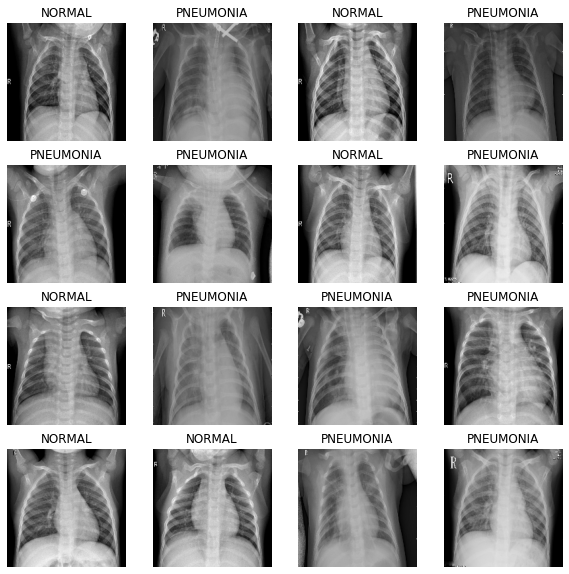

In [37]:
# 데이터 전처리 과정
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

BATCH_SIZE = 16 # 기존 16
EPOCHS = 10 # 에포크 10

def prepare_for_test(ds):
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
test_ds = prepare_for_test(test_ds)

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        image = np.clip(image_batch[n], 0, 1)  # 이미지를 유효한 범위로 클리핑
        plt.imshow(image)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [38]:
# 모델 직접 만들기
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 첫번째 모델 실험



In [39]:
# 학습시키기 위한 컴파일

with tf.device('/GPU:0'):
    model1 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    # optimizer = Adam, loss function은 답이 2종류라서 binary_crossentropy, 메트릭은 3개 사용 
    model1.compile(
        optimizer='RMSprop',
        loss='binary_crossentropy',
        metrics=METRICS
    )

# BATCH_SIZE, EPOCHS
BATCH_SIZE = 16 # 기존 16
EPOCHS = 10 # 에포크 10

# 가중치 설정 -  전체 개수 * 노멀개수 * 2 
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 # 2를 왜 나눌까? 가중치 합이 1에 가까워지도록 2를 나눈다.
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [40]:
with tf.device('/GPU:0'):
    history1 = model1.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 61s 195ms/step - loss: 0.3939 - accuracy: 0.8094 - precision: 0.9520 - recall: 0.7836 - val_loss: 0.7257 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 50s 192ms/step - loss: 0.2351 - accuracy: 0.9114 - precision: 0.9692 - recall: 0.9100 - val_loss: 1.4855 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 51s 194ms/step - loss: 0.1929 - accuracy: 0.9313 - precision: 0.9756 - recall: 0.9306 - val_loss: 0.1036 - val_accuracy: 0.9625 - val_precision: 0.9629 - val_recall: 0.9869
Epoch 4/10
261/261 [==============================] - 51s 194ms/step - loss: 0.1908 - accuracy: 0.9389 - precision: 0.9770 - recall: 0.9402 - val_loss: 1.3750 - val_accuracy: 0.7337 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 52s 201ms/step - loss: 0.1529 - accura

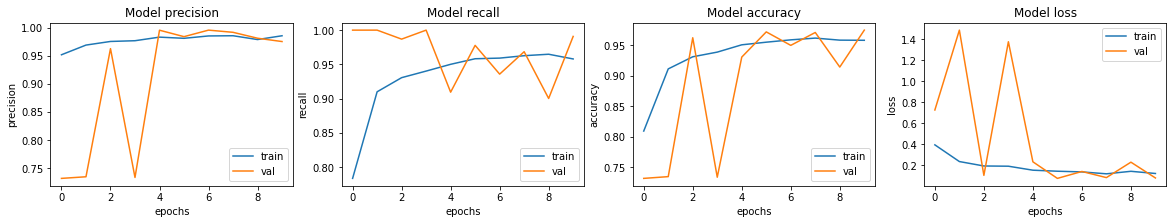

In [41]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history1.history[met])
    ax[i].plot(history1.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [42]:
loss, accuracy, precision, recall = model1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 114ms/step - loss: 1.0947 - accuracy: 0.7596 - precision: 0.7247 - recall: 0.9923
Loss: 1.0947277545928955,
Accuracy: 0.7596153616905212,
Precision: 0.7247191071510315,
Recall: 0.9923076629638672


# 두번째 실험 - 데이터 증강

In [11]:
# ***데이터 증강 추가***
def augment(image, label):
    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image)    # 상하 반전
    
    return image, label

In [12]:
# 데이터 증강
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) # train data processing
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)  # 데이터 증강 추가
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) # validation data processing
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) # test data processing

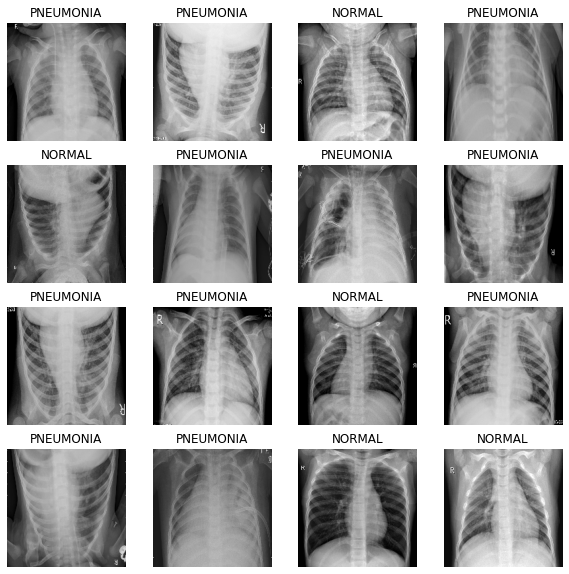

In [13]:
# 데이터 전처리
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
test_ds = prepare_for_test(test_ds)

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [14]:
# 학습시키기 위한 컴파일

with tf.device('/GPU:0'):
    model2 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    # optimizer = Adam, loss function은 답이 2종류라서 binary_crossentropy, 메트릭은 3개 사용 
    model2.compile(
        optimizer='RMSprop',
        loss='binary_crossentropy',
        metrics=METRICS
    )

# BATCH_SIZE, EPOCHS
BATCH_SIZE = 16 # 기존 16
EPOCHS = 10 # 에포크 10

# 가중치 설정 -  전체 개수 * 노멀개수 * 2 
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))
COUNT_NORMAL + COUNT_PNEUMONIA, TRAIN_IMG_COUNT, weight_for_0 + weight_for_1 , COUNT_PNEUMONIA/COUNT_NORMAL

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


(4185, 4185, 2.627357075351405, 2.911214953271028)

In [15]:
with tf.device('/GPU:0'):
    history2 = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 64s 205ms/step - loss: 0.5470 - accuracy: 0.7189 - precision: 0.9129 - recall: 0.6879 - val_loss: 0.5958 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 53s 204ms/step - loss: 0.3430 - accuracy: 0.8546 - precision: 0.9596 - recall: 0.8401 - val_loss: 0.5187 - val_accuracy: 0.8442 - val_precision: 0.9950 - val_recall: 0.7913
Epoch 3/10
261/261 [==============================] - 53s 202ms/step - loss: 0.2776 - accuracy: 0.8954 - precision: 0.9665 - recall: 0.8904 - val_loss: 0.2264 - val_accuracy: 0.9163 - val_precision: 0.9760 - val_recall: 0.9081
Epoch 4/10
261/261 [==============================] - 53s 204ms/step - loss: 0.2818 - accuracy: 0.8903 - precision: 0.9639 - recall: 0.8856 - val_loss: 0.1830 - val_accuracy: 0.9375 - val_precision: 0.9703 - val_recall: 0.9435
Epoch 5/10
261/261 [==============================] - 53s 204ms/step - loss: 0.2356 - accura

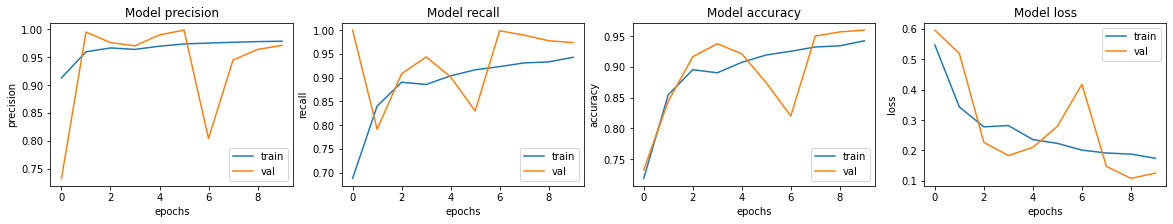

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [17]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 102ms/step - loss: 0.9548 - accuracy: 0.7436 - precision: 0.7130 - recall: 0.9872
Loss: 0.9548077583312988,
Accuracy: 0.7435897588729858,
Precision: 0.7129629850387573,
Recall: 0.9871794581413269


# 세번째 실험 - 하이퍼 파라미터 수정 

In [18]:
# 데이터 증강 제외
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) # train data processing
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) # validation data processing
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) # test data processing

In [19]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
test_ds = prepare_for_test(test_ds)

In [20]:
# 학습시키기 위한 컴파일

with tf.device('/GPU:0'):
    model3 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    # optimizer = Adam, loss function은 답이 2종류라서 binary_crossentropy, 메트릭은 3개 사용 
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

# BATCH_SIZE, EPOCHS
BATCH_SIZE = 8 # 기존 16
EPOCHS = 15 # 에포크 10

# 가중치 설정 -  전체 개수 * 노멀개수 * 2 
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 # 2를 왜 나눌까? 가중치 합이 1에 가까워지도록 2를 나눈다.
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))
COUNT_NORMAL + COUNT_PNEUMONIA, TRAIN_IMG_COUNT, weight_for_0 + weight_for_1 , COUNT_PNEUMONIA/COUNT_NORMAL

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


(4185, 4185, 2.627357075351405, 2.911214953271028)

In [21]:
with tf.device('/GPU:0'):
    history3 = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
523/523 [==============================] - 105s 183ms/step - loss: 0.3535 - accuracy: 0.8371 - precision: 0.9527 - recall: 0.8219 - val_loss: 1.4368 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/15
523/523 [==============================] - 95s 182ms/step - loss: 0.1993 - accuracy: 0.9301 - precision: 0.9751 - recall: 0.9298 - val_loss: 0.1533 - val_accuracy: 0.9370 - val_precision: 0.9286 - val_recall: 0.9902
Epoch 3/15
523/523 [==============================] - 95s 182ms/step - loss: 0.1661 - accuracy: 0.9401 - precision: 0.9809 - recall: 0.9379 - val_loss: 0.0792 - val_accuracy: 0.9673 - val_precision: 0.9790 - val_recall: 0.9764
Epoch 4/15
523/523 [==============================] - 94s 180ms/step - loss: 0.1528 - accuracy: 0.9425 - precision: 0.9824 - recall: 0.9396 - val_loss: 0.2509 - val_accuracy: 0.9192 - val_precision: 0.9985 - val_recall: 0.8911
Epoch 5/15
523/523 [==============================] - 97s 185ms/step - loss: 0.1278 - accur

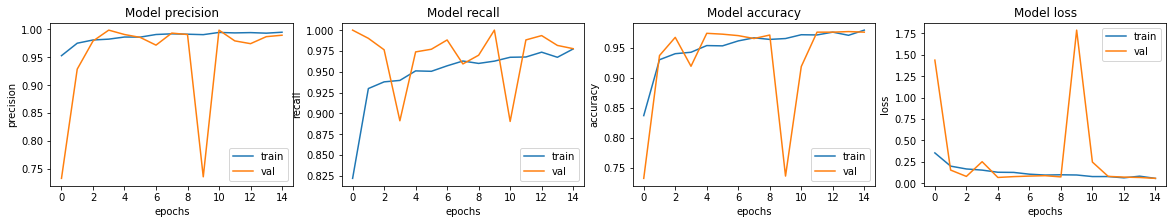

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 1.2647 - accuracy: 0.7772 - precision: 0.7400 - recall: 0.9923
Loss: 1.264716386795044,
Accuracy: 0.7772436141967773,
Precision: 0.7399617433547974,
Recall: 0.9923076629638672


# 4번째 - 가중치 제거시 어떻게될까?

In [32]:
# 학습시키기 위한 컴파일

with tf.device('/GPU:0'):
    model4 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    # optimizer = Adam, loss function은 답이 2종류라서 binary_crossentropy, 메트릭은 3개 사용 
    model4.compile(
        optimizer='RMSprop',
        loss='binary_crossentropy',
        metrics=METRICS
    )

# BATCH_SIZE, EPOCHS
BATCH_SIZE = 16 # 기존 16
EPOCHS = 10 # 에포크 10

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


(4185, 4185, 2.627357075351405, 2.911214953271028)

In [33]:
with tf.device('/GPU:0'):
    history4 = model4.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        # class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 61s 196ms/step - loss: 0.3570 - accuracy: 0.8568 - precision: 0.9377 - recall: 0.8653 - val_loss: 0.9739 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 197ms/step - loss: 0.2024 - accuracy: 0.9301 - precision: 0.9486 - recall: 0.9578 - val_loss: 1.5693 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 198ms/step - loss: 0.1726 - accuracy: 0.9428 - precision: 0.9596 - recall: 0.9637 - val_loss: 0.1951 - val_accuracy: 0.9135 - val_precision: 0.8985 - val_recall: 0.9948
Epoch 4/10
261/261 [==============================] - 52s 200ms/step - loss: 0.1619 - accuracy: 0.9471 - precision: 0.9614 - recall: 0.9678 - val_loss: 1.4994 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 52s 201ms/step - loss: 0.1628 - accura

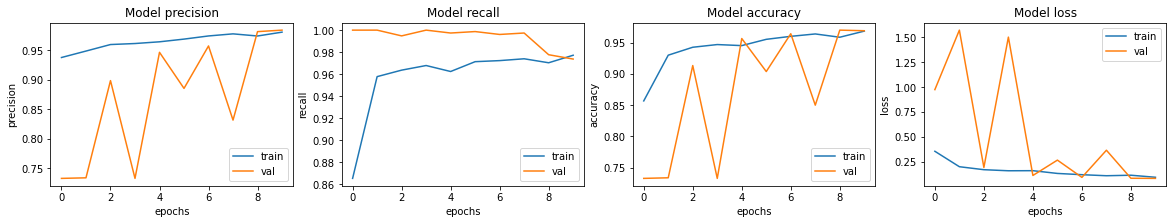

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history4.history[met])
    ax[i].plot(history4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [35]:
loss, accuracy, precision, recall = model4.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 0.6984 - accuracy: 0.7997 - precision: 0.7634 - recall: 0.9846
Loss: 0.6984289884567261,
Accuracy: 0.7996794581413269,
Precision: 0.763419508934021,
Recall: 0.9846153855323792


# 5번째 

In [28]:
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.optimizers import RMSprop,Adam

In [29]:
pretrained_model = ResNet50(weights= 'imagenet', include_top=False, input_shape= (180,180,3))

# layer freezing시키기
for layers in pretrained_model.layers:
    layers.trainable = False

    # 
last_layer = pretrained_model.get_layer('conv5_block3_1_relu')
last_output = last_layer.output

x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(1,activation='sigmoid')(x)

model5=tf.keras.Model(pretrained_model.input,x)

model5.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
               metrics=['accuracy','Precision','Recall'])

BATCH_SIZE = 16 # 기존 16
EPOCHS = 10 # 에포크 10

with tf.device('/GPU:0'):
    history5 = model5.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/10
261/261 [==============================] - 63s 197ms/step - loss: 0.8281 - accuracy: 0.5663 - precision: 0.7847 - recall: 0.5748 - val_loss: 0.5007 - val_accuracy: 0.8308 - val_precision: 0.8522 - val_recall: 0.9304
Epoch 2/10
261/261 [==============================] - 51s 196ms/step - loss: 0.5116 - accuracy: 0.7428 - precision: 0.8999 - recall: 0.7368 - val_loss: 0.2967 - val_accuracy: 0.8750 - val_precision: 0.9321 - val_recall: 0.8956
Epoch 3/10
261/261 [==============================] - 50s 190ms/step - loss: 0.4165 - accuracy: 0.8000 - precision: 0.9319 - recall: 0.7889 - val_loss: 0.2597 - val_accuracy: 0.8875 - val_precision: 0.9523 - val_recall: 0.8911
Epoch 4/10
261/261 [==============================] - 52s 200ms/step - loss: 0.3895 - accuracy: 0.8161 - precision: 0.9444 - recall: 0.7995 - val_loss: 0.2842 - val_accuracy: 0.8654 - val_precision: 0.9785 - val_recall: 0.8349
Epoch 5/10
261/261 [=======

39/39 [==============================] - 5s 118ms/step - loss: 0.4094 - accuracy: 0.8397 - precision: 0.8341 - recall: 0.9282
Loss: 0.4094178378582001,
Accuracy: 0.8397436141967773,
Precision: 0.8341013789176941,
Recall: 0.928205132484436


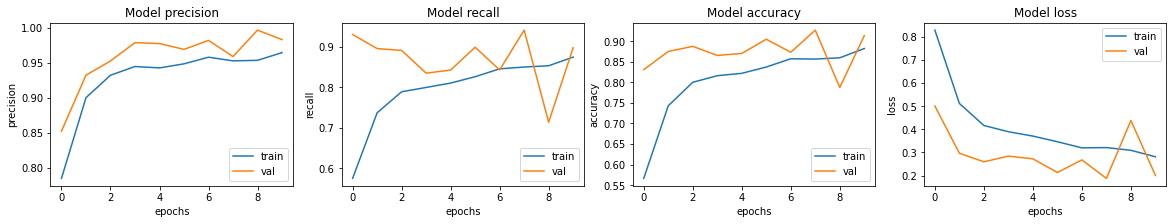

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history5.history[met])
    ax[i].plot(history5.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


loss, accuracy, precision, recall = model5.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')